In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.image as mpimg
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import matplotlib.patches as patches
import os
import math
from os import listdir
from os.path import isfile, join
from PIL import Image
from torch.autograd import Variable
import cv2
from torchvision.utils import save_image

def truncated_normal_(tensor, mean=0, std=1):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset Setup

In [4]:
start_dir = "/home/paperspace/zen/"

cufs_imgs_dir = start_dir + "CIS-680-Final-Project/HW3/data/cufs/imgs/"

In [5]:
class cufs_Data(Dataset):
    __xs = []
    __ys = []

    def __init__(self, folder_dataset, transform=None):
        self.transform = transform
        # Open and load text file including the whole training data
        with open(folder_dataset + "data.txt") as f:
            for line in f:
                self.__xs.append(folder_dataset + line.strip())

    # Override to give PyTorch access to any image on the dataset
    def __getitem__(self, index):
        img = Image.open(self.__xs[index])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        # Convert image and label to torch tensors
        img = torch.from_numpy(np.asarray(img))
        return img, []

    # Override to give PyTorch size of dataset
    def __len__(self):
        return len(self.__xs)

In [6]:
files = os.listdir(cufs_imgs_dir)
imgs = [i for i in files if i.endswith("png")]

np.random.seed(0)
num_train = len(imgs)
indices = list(range(num_train))
split = int(num_train/5)

# Random, non-contiguous split
test_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(test_idx))
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

transform_img = transforms.Compose(
    [transforms.ToTensor()])
dset_train = cufs_Data(cufs_imgs_dir, transform = transform_img)
train_loader = DataLoader(dset_train, batch_size=10, shuffle=False, num_workers=1, sampler=train_sampler)
test_loader = DataLoader(dset_train, batch_size=10, shuffle=False, num_workers=1, sampler=test_sampler)

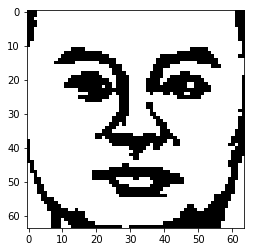

Process Process-1:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/selectors.py",

In [7]:
dataiter = iter(train_loader)
inputs, _ = dataiter.next()
img = np.transpose(inputs[0].numpy(), (1,2,0))
plt.imshow(img)

## Q1
### 1.1

In [7]:
epochs = 100
batch_size = 10

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encode_conv1 = nn.Conv2d(3, 8, 3, stride=2, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(8)
        self.encode_conv2 = nn.Conv2d(8, 16, 3, stride=2, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.encode_conv3 = nn.Conv2d(16, 32, 3, stride=2, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(32)
        self.encode_conv4 = nn.Conv2d(32, 64, 3, stride=2, padding = 1)
        self.conv4_bn = nn.BatchNorm2d(64)
        
        self.ln_encode = nn.Linear(1024, 64)
        
        self.decode_conv1 = nn.Conv2d(1, 64, 3, stride=1, padding = 1)
        self.conv1_decode_bn = nn.BatchNorm2d(64)
        self.decode_trans_conv1 = nn.ConvTranspose2d(64, 32, 3, stride=3, padding=1)
        self.conv1_trans_bn = nn.BatchNorm2d(32)
        self.decode_trans_conv2 = nn.ConvTranspose2d(32, 16, 3, stride=3, padding=1)
        self.conv2_trans_bn = nn.BatchNorm2d(16)
        self.decode_conv2 = nn.Conv2d(16, 3, 3, stride=1, padding = 1)
        

    def encode(self, x):
        x = F.relu(self.conv1_bn(self.encode_conv1(x)))
        x = F.relu(self.conv2_bn(self.encode_conv2(x)))
        x = F.relu(self.conv3_bn(self.encode_conv3(x)))
        x = F.relu(self.conv4_bn(self.encode_conv4(x)))
        
        return self.ln_encode(x.view(-1,1024))

    def decode(self, z):
        z = F.relu(self.conv1_decode_bn(self.decode_conv1(z)))
        z = F.relu(self.conv1_trans_bn(self.decode_trans_conv1(z)))
        z = F.relu(self.conv2_trans_bn(self.decode_trans_conv2(z)))
        z = self.decode_conv2(z)
        return torch.sigmoid(z)

    def forward(self, x):
        code = self.encode(x)
        return self.decode(code.view(-1,1,8,8))


model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

#### Training

Train Epoch: 0 Loss: 0.024253


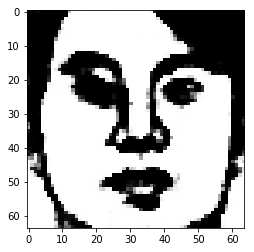

Train Epoch: 200 Loss: 0.024022


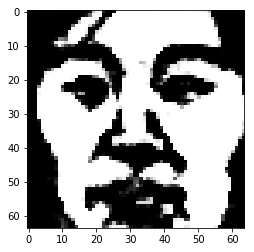

Train Epoch: 400 Loss: 0.023398


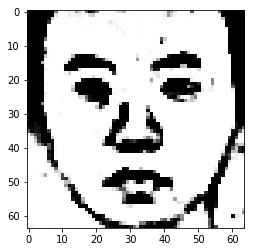

Train Epoch: 600 Loss: 0.022805


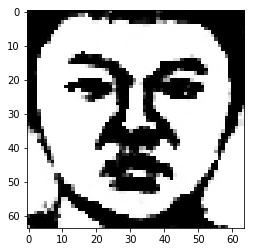

Train Epoch: 800 Loss: 0.022143


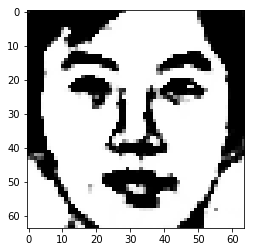

In [12]:
train_array = []
for i in range(1000):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon = model(data)
        loss = criterion(recon, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    train_array.append(train_loss)
    if i %200 == 0:
        print("Train Epoch: {} Loss: {:.6f}".format(i,train_loss/batch_idx))
        img = np.transpose(recon[0].cpu().detach().numpy(), (1,2,0))
        plt.imshow(img)
        plt.show()

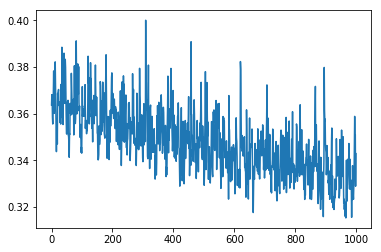

In [13]:
plt.plot(train_array)

#### Testing Set Visulization

In [7]:
with torch.no_grad():
    for batch_idx, (data, _) in enumerate(test_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon = model(data)
        
        f, axarr = plt.subplots(2,5)
        f.set_figheight(5)
        f.set_figwidth(10)
        for i in range(5):
            imgorg = np.transpose(data[i].cpu().detach().numpy(), (1,2,0))
            imgrec = np.transpose(recon[i].cpu().detach().numpy(), (1,2,0))
            axarr[0,i].imshow(imgorg)
            axarr[1,i].imshow(imgrec)
            
        plt.show()
        print("------------------------------------------")

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fa1e3792390>>
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/paperspace/anaconda3/envs/cv/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/paperspace/anacon

NameError: name 'optimizer' is not defined

### 1.2

In [79]:
epochs = 1000
batch_size = 10
interval = 200
    
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encode_conv1 = nn.Conv2d(3, 8, 3, stride=2, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(8)
        self.encode_conv2 = nn.Conv2d(8, 16, 3, stride=2, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.encode_conv3 = nn.Conv2d(16, 32, 3, stride=2, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(32)
        self.encode_conv4 = nn.Conv2d(32, 64, 3, stride=2, padding = 1)
        self.conv4_bn = nn.BatchNorm2d(64)
        
        self.ln_encode_mean = nn.Linear(1024, 64)
        self.ln_encode_variance = nn.Linear(1024, 64)
        self.ln_decode_variance = nn.Linear(64, 1024)
        
        self.decode_trans_conv1 = nn.ConvTranspose2d(1024, 128, 5, stride=2)
        self.conv1_trans_bn = nn.BatchNorm2d(128)
        self.decode_trans_conv2 = nn.ConvTranspose2d(128, 64, 5, stride=2)
        self.conv2_trans_bn = nn.BatchNorm2d(64)
        self.decode_trans_conv3 = nn.ConvTranspose2d(64, 32, 6, stride=2)
        self.conv3_trans_bn = nn.BatchNorm2d(32)
        self.decode_trans_conv4 = nn.ConvTranspose2d(32, 3, 6, stride=2)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        x = F.relu(self.conv1_bn(self.encode_conv1(x)))
        x = F.relu(self.conv2_bn(self.encode_conv2(x)))
        x = F.relu(self.conv3_bn(self.encode_conv3(x)))
        x = F.relu(self.conv4_bn(self.encode_conv4(x)))
        
        return self.ln_encode_mean(x.view(-1,1024)), self.ln_encode_variance(x.view(-1,1024))

    def decode(self, z):
        z = self.ln_decode_variance(z)
        z = F.relu(self.conv1_trans_bn(self.decode_trans_conv1(z.view(-1,1024,1,1))))
        z = F.relu(self.conv2_trans_bn(self.decode_trans_conv2(z)))
        z = F.relu(self.conv3_trans_bn(self.decode_trans_conv3(z)))
        z = self.decode_trans_conv4(z)
        return self.sigmoid(z)

    def forward(self, x):
        mean, log_variance = self.encode(x)
        std = torch.exp(0.5*log_variance)
        ns = torch.randn_like(std) #return N(0,1)

        code = ns * std + mean
        return self.decode(code), mean, log_variance


    
    
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

====> Epoch: 0 Average loss: 6086.4793


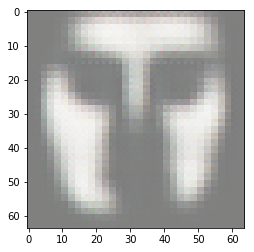

====> Epoch: 200 Average loss: 194.9106


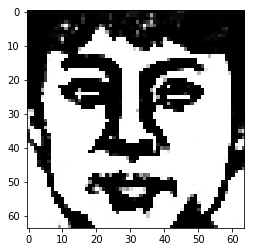

====> Epoch: 400 Average loss: 102.2240


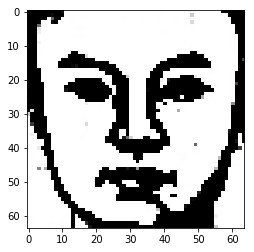

====> Epoch: 600 Average loss: 60.8130


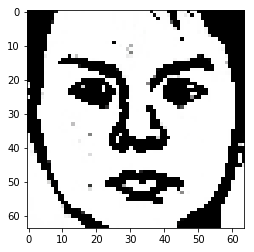

====> Epoch: 800 Average loss: 63.1815


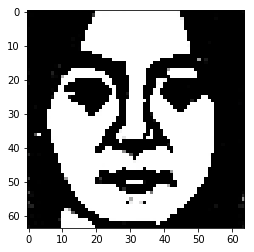

In [80]:

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mean, logvariance):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 12288), reduction='sum')
    KLD = 0.5 * torch.sum(mean.pow(2) + logvariance.exp() - logvariance - 1)

    return BCE + KLD


def train(epochs):
    loss_array = []
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon, mu, logvariance = vae(data)
            loss = loss_function(recon, data, mu, logvariance)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        if epoch % interval == 0:
            print('====> Epoch: {} Average loss: {:.4f}'.format(
                  epoch, train_loss / len(train_loader.dataset)))
            img = np.transpose(recon[0].cpu().detach().numpy(), (1,2,0))
            plt.imshow(img)
            plt.show()
        loss_array.append(train_loss / len(train_loader.dataset))
    return loss_array


loss_array = train(epochs)

In [81]:
torch.save(vae.state_dict(), "vae")

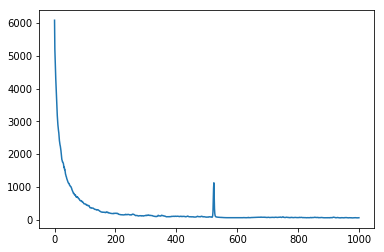

In [82]:
plt.plot(loss_array)

### Test Visulization

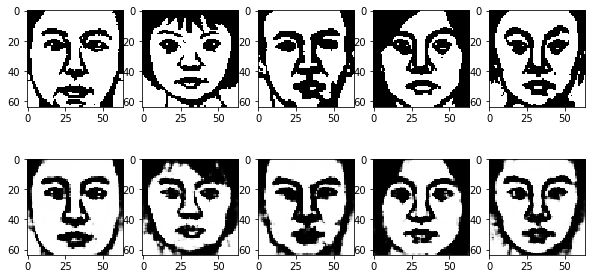

------------------------------------------


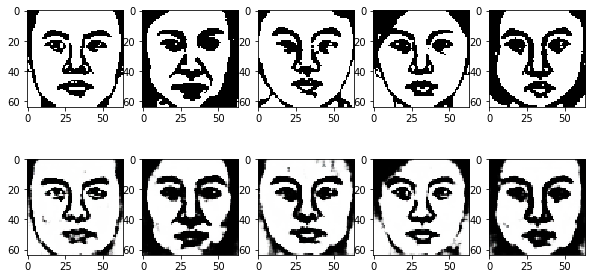

------------------------------------------


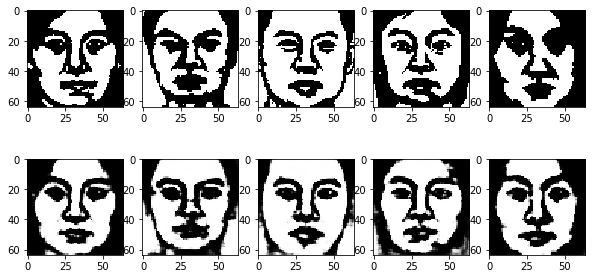

------------------------------------------


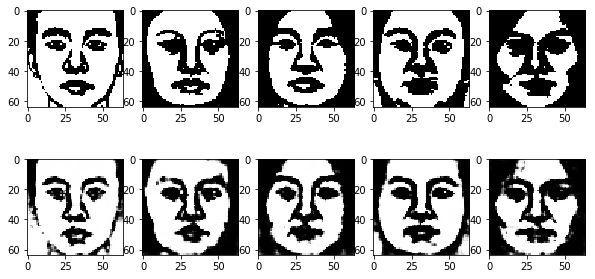

------------------------------------------


In [83]:
vae = VAE().to(device)
vae.load_state_dict(torch.load("vae4"))
with torch.no_grad():
    for batch_idx, (data, _) in enumerate(test_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon, mean, logvariance = vae(data)
        
        f, axarr = plt.subplots(2,5)
        f.set_figheight(5)
        f.set_figwidth(10)
        for i in range(5):
            
            imgorg = np.transpose(data[i].cpu().detach().numpy(), (1,2,0))
            imgrec = np.transpose(recon[i].cpu().detach().numpy(), (1,2,0))
            axarr[0,i].imshow(imgorg)
            axarr[1,i].imshow(imgrec)
            
        plt.show()
        print("------------------------------------------")

#### Random Generlization

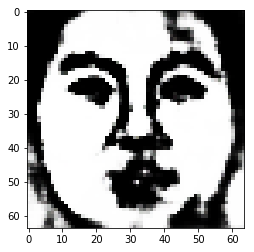

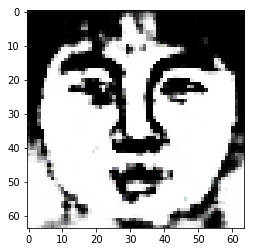

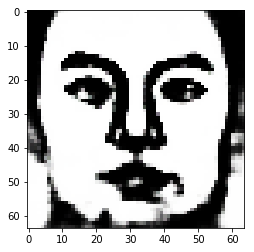

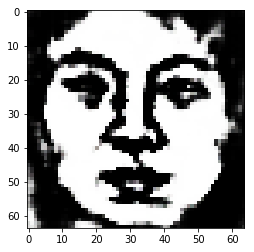

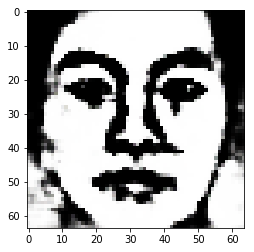

In [84]:
with torch.no_grad():
    sample = torch.randn(5,64).to(device)
    sample = vae.decode(sample.view(5,1,64)).cpu()
    for i in range(5):
        img = np.transpose(sample[i].cpu().detach().numpy(), (1,2,0))
        plt.imshow(img)
        plt.show()